In [77]:
#OBJECTIEVES ->

#1. SOLVE DATA IMBALANCE
#2. DRAW FANCY GRAPHS
#3. USE ONECYCLE_LR, DIFF_LR
#4. MORE AUGMENTATION
#5. VISION TRANSFORMER to classift disaster or non disaster

In [78]:
!pip install timm

In [79]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import timm
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [80]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

#will convert to GPU when required

Using device: cuda


## Class Names

In [81]:
class_names = {
    0: 'Water_Disaster',
    1: 'Non_Damaged_Wildlife_Forest',
    2: 'Non_Damaged_sea',
    3: 'Non_Damaged_Buildings_Street',
    4: 'Non_Damaged_human',
    5: 'Damaged_Infrastructure',
    6: 'Earthquake',
    7: 'Human_Damage',
    8: 'Urban_Fire',
    9: 'Wild_Fire',
    10: 'Land_Slide',
    11: 'Drought',
}

num_classes = len(class_names)

# GLOBAL VARS #

In [82]:
#Global Vars

train_ratio, val_ratio= 0.7, 0.3
batch_size = 2 #CHAGNE LATER
num_epochs = 1 #CHANGE LATER
max_images = 100000000

## Converting Kaggle Dataset to .csv

In [83]:

if os.path.exists("/kaggle/working/disaster_image_dataset.csv"):
    dataset_loaded_already = True
else:
    dataset_loaded_already = False

def get_image_paths_and_labels(root_dir):
    classes = []
    image_paths = []
    class_to_idx = {}
    current_class_idx = 0

    count = 0
    
    for root, subdirs, files in os.walk(root_dir):
        if not subdirs:
            class_name = os.path.relpath(root, root_dir)
            classes.append(class_name)
            class_to_idx[class_name] = current_class_idx
            current_class_idx += 1
    
            if count >= max_images:
                break
            
            # Get all image files in this class
            for file in files:
                if file.endswith(('.png', '.jpg', '.jpeg')):
                    image_paths.append((os.path.join(root, file), class_to_idx[class_name]))
                    count += 1

    #Adding a Fake Data Class so that the vision transformer can return 1 to that as [0,0,0,0,0,0,0,0,0,0,0,0,1]
    #class_to_idx["Fake"] = current_class_idx
    
    return image_paths, class_to_idx

root_dir = '/kaggle/input/disaster-images-dataset/Comprehensive Disaster Dataset(CDD)'

if not dataset_loaded_already:
    image_paths_and_labels, class_to_idx_dict = get_image_paths_and_labels(root_dir)
    num_of_classes = len(class_to_idx_dict)
    
    #Reversing the dictionary
    idx_to_class = {}
    
    for key, value in class_to_idx_dict.items():
        idx_to_class[value] = key
    
    disaster_image_dataset_dict = {
        "Image_Paths": [t[0] for t in image_paths_and_labels],
        "Labels": [t[1] for t in image_paths_and_labels]
    }
    
    #Dataframe
    disaster_image_dataset_df = pd.DataFrame(disaster_image_dataset_dict)
    
    #CSV file
    disaster_image_dataset_df.to_csv("disaster_image_dataset.csv", index=False)

    print(f"DataSaved as 'disaster_image_dataset.csv' ")

In [84]:
idx_to_class

{0: 'Water_Disaster',
 1: 'Non_Damage/Non_Damage_Wildlife_Forest',
 2: 'Non_Damage/sea',
 3: 'Non_Damage/Non_Damage_Buildings_Street',
 4: 'Non_Damage/human',
 5: 'Damaged_Infrastructure/Infrastructure',
 6: 'Damaged_Infrastructure/Earthquake',
 7: 'Human_Damage',
 8: 'Fire_Disaster/Urban_Fire',
 9: 'Fire_Disaster/Wild_Fire',
 10: 'Land_Disaster/Land_Slide',
 11: 'Land_Disaster/Drought'}

In [85]:
disaster_dataset = pd.read_csv('/kaggle/input/disaster-images-data/disaster_image_dataset (2).csv')

## Dataset

In [86]:
disaster_dataset

,Image_Paths,Labels
0,/kaggle/input/disaster-images-dataset/Comprehe...,0
1,/kaggle/input/disaster-images-dataset/Comprehe...,0
2,/kaggle/input/disaster-images-dataset/Comprehe...,0
3,/kaggle/input/disaster-images-dataset/Comprehe...,0
4,/kaggle/input/disaster-images-dataset/Comprehe...,0
...,...,...
13552,/kaggle/input/disaster-images-dataset/Comprehe...,11
13553,/kaggle/input/disaster-images-dataset/Comprehe...,11
13554,/kaggle/input/disaster-images-dataset/Comprehe...,11
13555,/kaggle/input/disaster-images-dataset/Comprehe...,11


# EDA #


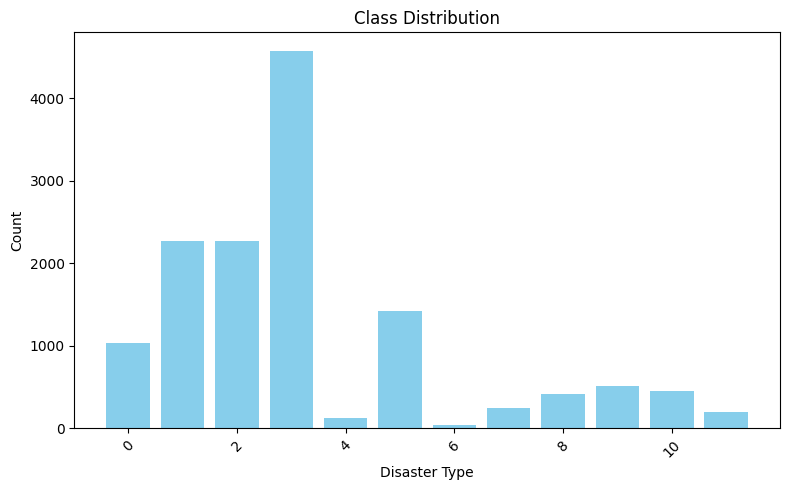

In [87]:
import matplotlib.pyplot as plt

# Count values
counts = disaster_dataset['Labels'].value_counts()

# Plot
plt.figure(figsize=(8, 5))
plt.bar(counts.index, counts.values, color='skyblue')

plt.title("Class Distribution")
plt.xlabel("Disaster Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Inference

#### I will have to use some techniques to tackle this class imbalance

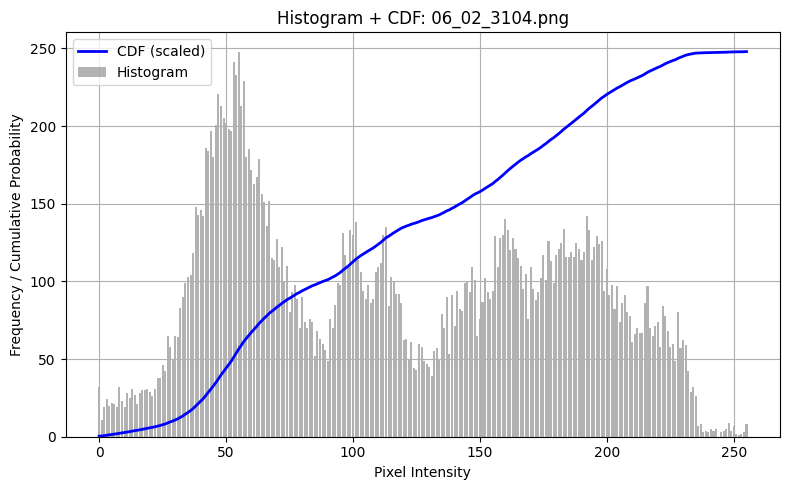

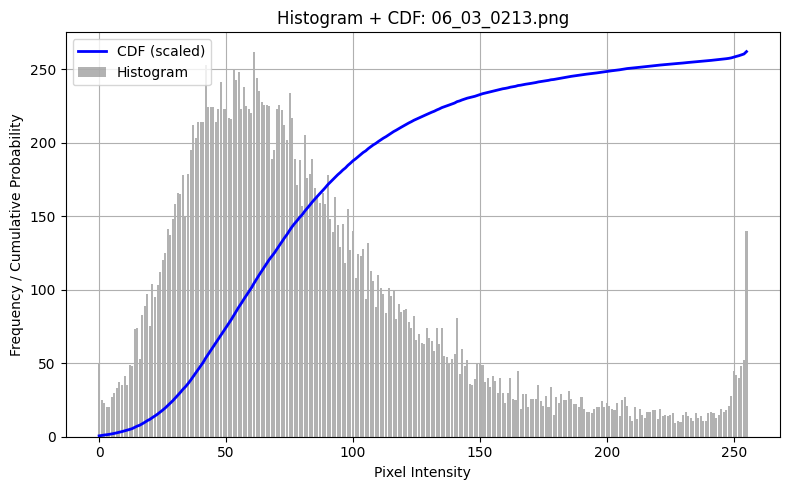

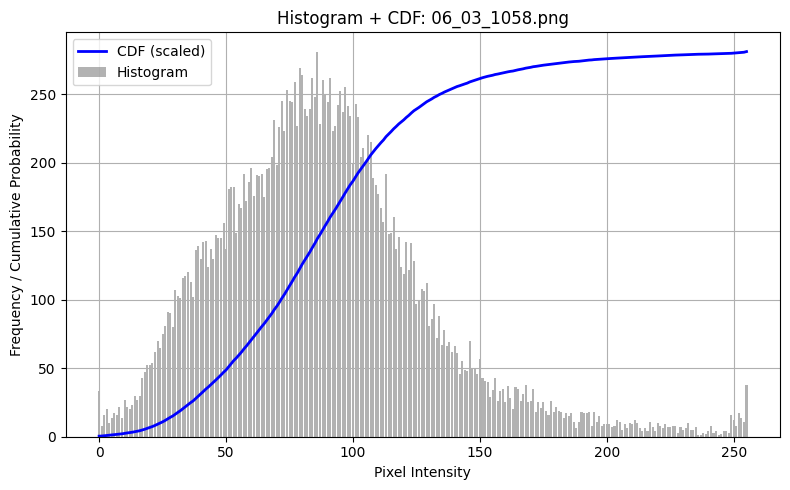

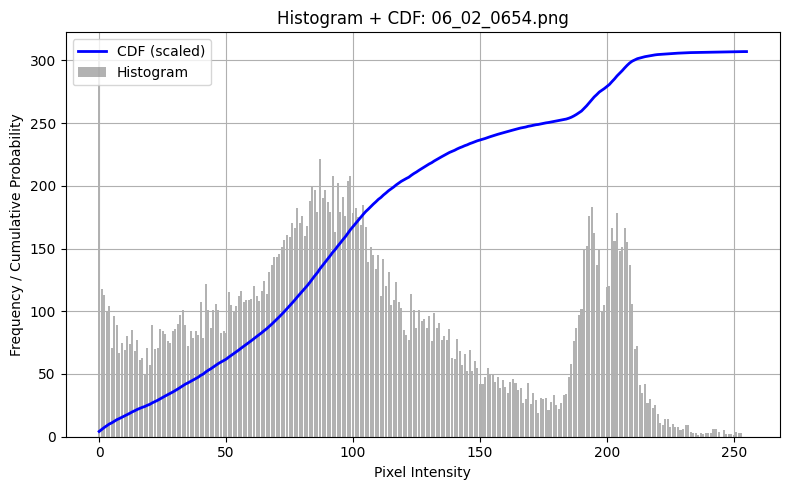

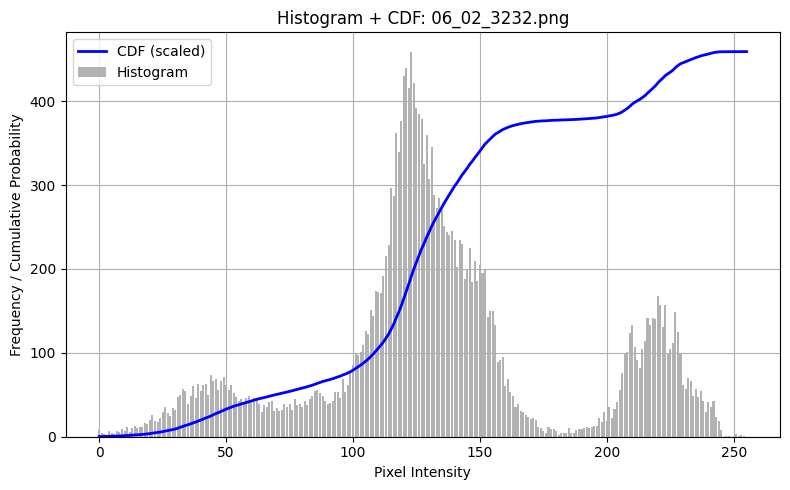

In [88]:
import cv2
import matplotlib.pyplot as plt
import random
import os
import numpy as np

def plot_histogram_with_cdf(image_paths, sample_size=5):
    sample_paths = random.sample(image_paths, min(sample_size, len(image_paths)))

    for path in sample_paths:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

        # Compute histogram
        hist = cv2.calcHist([img], [0], None, [256], [0, 256]).ravel()
        hist_norm = hist / hist.sum()  # Normalize
        cdf = hist_norm.cumsum()

        plt.figure(figsize=(8, 5))

        plt.title(f'Histogram + CDF: {os.path.basename(path)}')
        plt.xlabel('Pixel Intensity')
        plt.ylabel('Frequency / Cumulative Probability')

        # Plot histogram (bar chart)
        plt.bar(range(256), hist, color='gray', alpha=0.6, label='Histogram')

        # Plot CDF (line)
        plt.plot(cdf * hist.max(), color='blue', linewidth=2, label='CDF (scaled)')  # scale CDF to match histogram scale

        plt.legend(loc='upper left')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Example usage
plot_histogram_with_cdf(disaster_dataset["Image_Paths"].to_list())

# Inference

#### We see in Grayscale that some images are too dark and some are bright and there is not uniformness so we will use CLAHE. 
#### What is CLAHE? -> Contrast limiting adaptige histo equalization -> better histo equalization cmopared to global histo equalization as differnet parts of images have differnt contrast.
#### this CLAHE  will be used in Dataset class

## Custom Image Dataset

In [89]:
from PIL import Image

class Custom_Image_Dataset(Dataset):
    
    def __init__(self, dis_df, apply_clahe=True):
        self.image_paths = dis_df["Image_Paths"]
        self.labels = dis_df["Labels"]
        self.apply_clahe = apply_clahe

        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet stats
                                 std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        path = self.image_paths[idx]
        label = self.labels[idx]

        try:
            img = Image.open(path)
            img.verify()
        except Exception as e:
            print(f"Removing corrupted image: {path}")
            os.remove(path)
        
        # Load image in BGR format using OpenCV
        if img is None:
            print(f"[Warning] Unable to read image at: {path}. Skipping...")
            return self.__getitem__((idx + 1) % len(self.image_paths))  # Try next image safely

        if self.apply_clahe:
            # Convert to LAB and apply CLAHE to L-channel
            lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
            l, a, b = cv2.split(lab)
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            cl = clahe.apply(l)
            lab = cv2.merge((cl, a, b))
            img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)  # Back to RGB
        else:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        img = Image.fromarray(img) #converts to tensor
        img = self.transform(img)
        return img, label

In [90]:
dataset_length = len(disaster_dataset)
train_size = int(train_ratio * dataset_length)
val_size = dataset_length - train_size
train_dataset, val_dataset= random_split(disaster_dataset, [train_size, val_size])

In [91]:
Disaster_Dataset = Custom_Image_Dataset(disaster_dataset)

# Custom Model

In [92]:
model = timm.create_model('efficientnet_lite0', pretrained=True, num_classes=num_classes)
model.to(device)

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): ReLU6(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU6(inplace=True)
        )
        (aa): Identity()
        (se): Identity()
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
        (drop_path): Identity()
      )
    )
    (1): Sequent

In [93]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

## Training

In [96]:
from sklearn.model_selection import StratifiedKFold

# Assuming these are already defined:
# dataset: your custom Dataset object
# labels_array: list or array of integer class labels
# model, optimizer, criterion, num_epochs, batch_size, device

def train_with_val_graphs(dataset, idx_to_class):

    num_classes = len(idx_to_class)
    print(f"Number of Classes: {num_classes}")
    
    n_splits = 5
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    labels_array = dataset.labels
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(labels_array)), labels_array)):
        print(f"\n===== Fold {fold + 1} =====")
        print(f"Train size: {len(train_idx)}, Val size: {len(val_idx)}")
    
        # Create DataLoaders for current fold
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)
    
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=4)
            
        start_time = time.time()
    
        #lists
        train_losses, val_losses, train_accuracies, val_accuracies, = [], [], [], []
        
        train_recalls = torch.zeros((num_epochs, num_classes), dtype=torch.float32, device=device)
        #val_recalls
        
        train_precisions = torch.zeros((num_epochs, num_classes), dtype=torch.float32, device=device)
        #val_precisions

        train_f1s = torch.zeros((num_epochs, num_classes), dtype=torch.float32, device=device)
        #val_precisions
    
        for epoch in range(num_epochs):
    
            print(f'Started epoch: {epoch}, using device:{device} ') 
            
            model.train()
    
            running_loss = 0.0
            running_corrects = 0.0
    
            tps = torch.zeros(num_classes, dtype=torch.float32, device=device)
            fns = torch.zeros(num_classes, dtype=torch.float32, device=device)
            fps = torch.zeros(num_classes, dtype=torch.float32, device=device)
    
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                #to zero out the gradients
                optimizer.zero_grad() 
    
                #forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
    
                #Update the params
                optimizer.step()
                
                _, preds = torch.max(outputs, 1)
                preds = preds.to(device)
                    
                #Scales up the loss
                running_loss += loss.item() * inputs.size(0)
                
                #preds is like 0,1,2... and laebls is also 0,1,2
                running_corrects += torch.sum(preds == labels)
    
                #For Recall and Precision
                for c in range(num_classes):
                    tps[c] += torch.sum((labels==c) & (preds == c))
                    fns[c] += torch.sum((labels==c) & (preds != c))
                    fps[c] += torch.sum((labels!=c) & (preds == c))
    
            eps = 1e-6
            
            def recall(true_pos, false_neg):
                return (true_pos/((true_pos + false_neg) + eps))
    
            def precision(true_pos, false_pos):
                return (true_pos/((true_pos + false_pos) + eps))

            def f1_score(recalls, precisions):
                return(2 * recalls * precisions /(recalls + precisions + eps))
            
            #Calculate Recall and Precision for each class ->
            for c in range(num_classes):
                train_recalls[epoch][c] = recall(tps[c], fns[c])
                train_precisions[epoch][c] = precision(tps[c], fps[c])
                train_f1_score[epoch][c] = f1_score(train_recalls[epoch][c], train_precisions[epoch][c])
            
            
            epoch_loss = running_loss / len(train_loader.dataset)
            epoch_acc = running_corrects.double() / len(train_loader.dataset)
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_acc.item())
    
            print('Entering Validation Phase....')
            
            #---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------#
             # Validation phase
            model.eval()
            running_loss = 0.0
            running_corrects = 0
    
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
    
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
    
                    _, preds = torch.max(outputs, 1)
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
    
            epoch_loss = running_loss / len(val_loader.dataset)
            epoch_acc = running_corrects.double() / len(val_loader.dataset)
            val_losses.append(epoch_loss)
            val_accuracies.append(epoch_acc.item())
    
    
            print('-' * 50)
            print(f'Epoch {epoch+1}/{num_epochs}, '
                  f'Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, '
                  f'Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}')
    
            for c in range(num_classes):
                print(f'For Class: {c}, Train Recall: {train_recalls[epoch][c]:.4f}, Train Precision: {train_precisions[epoch][c]:.4f}')
                print(f'For Class: {c}, Train F1 Score is: {train_f1s[epoch][c]}')
                
            
            print('-' * 50)
        
        # Plot training & validation loss and accuracy
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.legend()
        plt.title('Loss')
    
        plt.subplot(1, 2, 2)
        plt.plot(train_accuracies, label='Train Accuracy')
        plt.plot(val_accuracies, label='Validation Accuracy')
        plt.legend()
        plt.title('Accuracy')
    
        plt.show()
    
        end_time = time.time()
    
        print(f"Execution took: {end_time - start_time:.2f} secs")


In [ ]:
train_with_val_graphs(Disaster_Dataset, idx_to_class)

Number of Classes: 12

===== Fold 1 =====
Train size: 10845, Val size: 2712
Started epoch: 0, using device:cuda 


Premature end of JPEG file


[Warning] Unable to read image at: /kaggle/input/disaster-images-dataset/Comprehensive Disaster Dataset(CDD)/Human_Damage/02_0069.png. Skipping...
